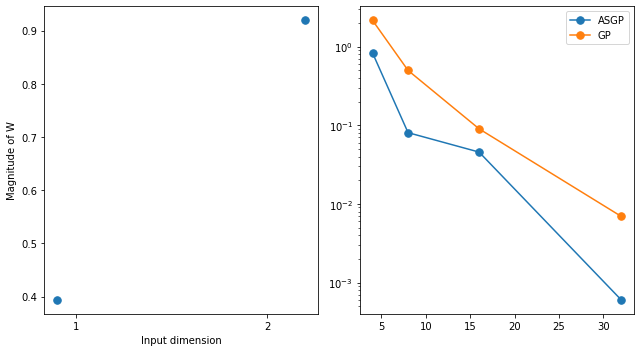

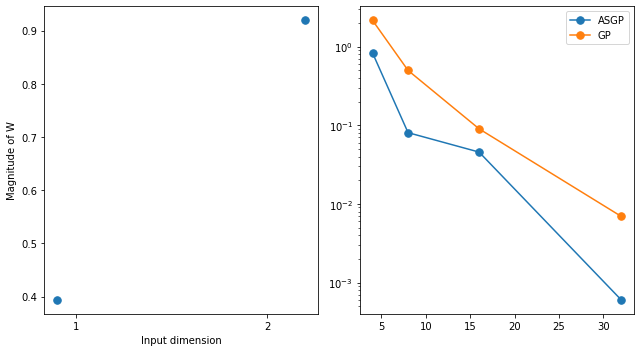

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

"""
Scheidegger & Bilionis (2017), 
Machine Learning for High-Dimensional Dynamic Stochastic Economies

https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2927400

The example below corresponds to figure 3 from the paper.
It demonstrates the procedure for constructing 
the active subspace and then compares the Gaussian process 
regression on the original subspace to the GPR on the active subspace.

"""
#test function
def test_function(x):
    return np.exp(0.3*x[0] + 0.7*x[1])


#gradient of test_function
def dtest_function(x):
    val = test_function(x)
    return np.column_stack([0.3*val, 0.7*val])

#Evaluating this function on points in \Omega = [-1,1]^2
def randOmega(N, D):
    "random points on \Omega = [-1,1]^D"
    return 2 * (np.random.rand(N, D) - 0.5)

def example1():
    np.random.seed(43)
    Nvals = np.array([4, 8, 16, 32])
    num_Ns = len(Nvals)
    ave_errs_as = np.inf * np.ones(num_Ns)
    ave_errs = np.inf * np.ones(num_Ns)
    
    # construct test points
    X_test = randOmega(1000, 2)
    f1_test = test_function(X_test.T)
    
    for i, N in enumerate(Nvals):
        # training points
        X = randOmega(N, 2)
        V = test_function(X.T)
        G = dtest_function(X.T)
        
        #find active subspace
        CN = (G.T @ G) / N
        vals, vecs = linalg.eigh(CN)
        W = vecs[:, 1]
        Y = X @ W
        
        # fit GP on active subspace
        #kernel =  C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
        kernel = RBF()
        
        gp_as = GaussianProcessRegressor(kernel)
        
        gp_as.fit(Y[:, None], V)
        m_tilde_as = gp_as.predict((X_test @ W)[:, None])
        ave_errs_as[i] = np.sqrt(np.sum((f1_test - m_tilde_as)**2 / (f1_test**2)) / N)
        
        # fit gp on input domain
        gp_as = GaussianProcessRegressor(RBF())
        gp_as.fit(X, V)
        m_tilde = gp_as.predict(X_test)
        ave_errs[i] = np.sqrt(np.sum((f1_test - m_tilde)**2 / (f1_test**2)) / N)

    
    fig, ax = plt.subplots(1, 2, figsize=(9, 5))
    ax[0].plot([0.9, 2.2], W, ".", ms=15)
    ax[0].set_xlabel("Input dimension")
    ax[0].set_xticks([1, 2])
    ax[0].set_ylabel("Magnitude of W")
    
    ax[1].semilogy(Nvals, ave_errs_as, ".-", label="ASGP", ms=15)
    ax[1].semilogy(Nvals, ave_errs, ".-", label="GP", ms=15)
    ax[1].legend()
    fig.tight_layout()
    plt.show()
    
    return fig

# run the example code for example 1
example1()